In [2]:
#imports
import torch
import numpy as np
import random
import math
import matplotlib.pyplot as plt

#modules
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchmetrics.classification import AUROC

#metrics import
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, multilabel_confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score
from statistics import mean

# select device as cuda
device = torch.device("cuda:0")

# set random seeds
seed = 1234 ## change this seed when you run trials
random.seed(seed) # random num generator needs a seed to start with
torch.manual_seed(seed) # returns torch generator object, functionality is same as above

In [3]:
class LinearFunction(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, W, b):
    """
    # x -> input matrix of size n_samples x sdim
    # W -> transformation matrix
    # b -> bias term 
    """
    ctx.save_for_backward(x, W, b)
    # Write your affine transformation here:
    #-------------------
#     print(f"AFFINE: X : {x.shape} W {W.shape} B {b.shape}")
    z = torch.matmul(x, W) + b
#     print(f"Z : {z.shape}")
    #-------------------
    return z
    
  @staticmethod
  def backward(ctx, grad_output):
    x, W, b = ctx.saved_tensors
    
    # Write gradient updates here:
    #----------------------------
#     print(f"BACKWARD : grad_output {grad_output.shape}, W {W.shape}, X {x.shape}")
    grad_x = torch.matmul(grad_output, W.T)
    grad_w = torch.matmul(grad_output.T, x).T
    grad_b = grad_output
#     print(f"grad_x {grad_x.shape}, grad_w {grad_w.shape}")
    #-----------------------------
    return grad_x, grad_w, grad_b

In [4]:
class CustomLinearLayer(torch.nn.Module):
  def __init__(self, in_features, out_features):
    super(CustomLinearLayer, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    w = torch.normal(mean = 0, std = 0.1, size = [in_features, out_features], requires_grad=True)
    b = torch.full([out_features], 0.01, requires_grad=True)
    w = torch.nn.Parameter(w)
    b = torch.nn.Parameter(b)
    self.register_parameter('w', w)
    self.register_parameter('b', b)
    self.linear_function = LinearFunction.apply
  
  def forward(self, x):
    return self.linear_function(x, self.w, self.b)
     



In [5]:
class NeuralNetwork(torch.nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    # Add Linear layers below 
    #-----------------------------------
    self.layer_1 = CustomLinearLayer(784, 512)
    self.layer_2 = CustomLinearLayer(512, 10)
    # ------------------------------------
    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    # Apply layers defined above:
    #-------------------------------
    output = self.layer_1(x)
    output = self.activation(output)
    output = self.layer_2(output)
    output = self.softmax(output)
    #-------------------------------
    return output

In [6]:
class CrossEntropyLoss(torch.nn.Module):
  def __init__(self):
    super(CrossEntropyLoss, self).__init__()
  
  def forward(self, probs, y):
    #Write loss function here:
    #-------------------------------
    # one-hot encoding
    loss = -torch.sum((torch.nn.functional.one_hot(y, num_classes=probs.shape[-1]) * torch.log(probs))) / float(probs.shape[0])
    #-------------------------------
    return loss
     

In [7]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# print(training_data[0]) #(28x28, 1x1 label)

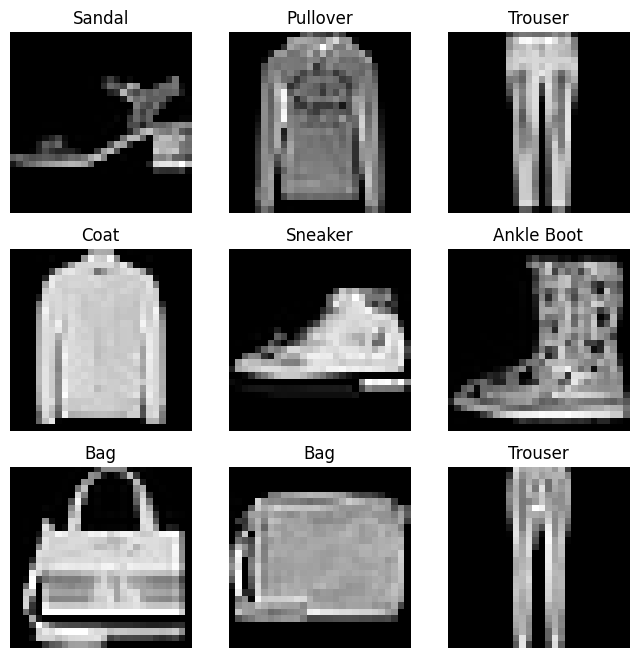

In [8]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [9]:
# split mnist trainset into two sets: mnist trainset -> 50000 , mnist validation set -> 10000
#----------------
train_data, val_data = torch.utils.data.random_split(training_data,[50000, 10000])

#----------------
     
# img, label = train_data[0]
# print(img.squeeze().shape, labels_map[label])

In [10]:
model = NeuralNetwork().cuda()
ce_loss = CrossEntropyLoss()

In [12]:
# from torch.utils.data import DataLoader
# train_loader = DataLoader(train_data, batch_size=1024)
# for idx, data in enumerate(train_loader):
#     images, labels = data
#     print(labels.shape)
#     print(images.reshape(-1, 784).shape) # allow numpy to determine the correct no of rows, flatten is a copy, reshape is a view

Epoch 0/10 Iteration 0/49 Loss 3.6421902179718018: 
Epoch 0/10 Iteration 1/49 Loss 2.8335654735565186: 
Epoch 0/10 Iteration 2/49 Loss 2.489055633544922: 
Epoch 0/10 Iteration 3/49 Loss 2.36944580078125: 
Epoch 0/10 Iteration 4/49 Loss 2.2263412475585938: 
Epoch 0/10 Iteration 5/49 Loss 2.039961814880371: 
Epoch 0/10 Iteration 6/49 Loss 1.9673542976379395: 
Epoch 0/10 Iteration 7/49 Loss 1.9270508289337158: 
Epoch 0/10 Iteration 8/49 Loss 1.909238338470459: 
Epoch 0/10 Iteration 9/49 Loss 1.829696536064148: 
Epoch 0/10 Iteration 10/49 Loss 1.736072301864624: 
Epoch 0/10 Iteration 11/49 Loss 1.6891040802001953: 
Epoch 0/10 Iteration 12/49 Loss 1.6831845045089722: 
Epoch 0/10 Iteration 13/49 Loss 1.6354825496673584: 
Epoch 0/10 Iteration 14/49 Loss 1.6609687805175781: 
Epoch 0/10 Iteration 15/49 Loss 1.5465052127838135: 
Epoch 0/10 Iteration 16/49 Loss 1.5746090412139893: 
Epoch 0/10 Iteration 17/49 Loss 1.5222101211547852: 
Epoch 0/10 Iteration 18/49 Loss 1.5270293951034546: 
Epoch 0/10

Epoch 2/10 Iteration 23/49 Loss 0.8465906977653503: 
Epoch 2/10 Iteration 24/49 Loss 0.9070987105369568: 
Epoch 2/10 Iteration 25/49 Loss 0.862891674041748: 
Epoch 2/10 Iteration 26/49 Loss 0.8374963998794556: 
Epoch 2/10 Iteration 27/49 Loss 0.8687813878059387: 
Epoch 2/10 Iteration 28/49 Loss 0.8150562644004822: 
Epoch 2/10 Iteration 29/49 Loss 0.894569993019104: 
Epoch 2/10 Iteration 30/49 Loss 0.8300513029098511: 
Epoch 2/10 Iteration 31/49 Loss 0.8137917518615723: 
Epoch 2/10 Iteration 32/49 Loss 0.8256519436836243: 
Epoch 2/10 Iteration 33/49 Loss 0.8700104355812073: 
Epoch 2/10 Iteration 34/49 Loss 0.8293503522872925: 
Epoch 2/10 Iteration 35/49 Loss 0.7978405952453613: 
Epoch 2/10 Iteration 36/49 Loss 0.7965618968009949: 
Epoch 2/10 Iteration 37/49 Loss 0.8327372670173645: 
Epoch 2/10 Iteration 38/49 Loss 0.8304025530815125: 
Epoch 2/10 Iteration 39/49 Loss 0.8292773962020874: 
Epoch 2/10 Iteration 40/49 Loss 0.7857129573822021: 
Epoch 2/10 Iteration 41/49 Loss 0.76821494102478

Epoch 4/10 Iteration 47/49 Loss 0.6799251437187195: 
Epoch 4/10 Iteration 48/49 Loss 0.7133809328079224: 
Accuracy : 75.63 

SK LEARN Accuracy: 0.7563
Classification Report : 
               precision    recall  f1-score   support

         0.0       0.73      0.74      0.74       984
         1.0       0.94      0.93      0.93       998
         2.0       0.64      0.61      0.62       970
         3.0       0.78      0.83      0.80      1019
         4.0       0.63      0.68      0.65      1031
         5.0       0.85      0.71      0.78      1016
         6.0       0.50      0.42      0.46       993
         7.0       0.79      0.83      0.81       980
         8.0       0.87      0.90      0.88      1006
         9.0       0.81      0.90      0.86      1003

    accuracy                           0.76     10000
   macro avg       0.75      0.76      0.75     10000
weighted avg       0.75      0.76      0.75     10000
 

F1_SCORE : 0.7530369346904257
Precision : 0.7532268177131052
R

Epoch 7/10 Iteration 2/49 Loss 0.6342658400535583: 
Epoch 7/10 Iteration 3/49 Loss 0.6727749705314636: 
Epoch 7/10 Iteration 4/49 Loss 0.6831573247909546: 
Epoch 7/10 Iteration 5/49 Loss 0.6610066890716553: 
Epoch 7/10 Iteration 6/49 Loss 0.6417051553726196: 
Epoch 7/10 Iteration 7/49 Loss 0.6590247750282288: 
Epoch 7/10 Iteration 8/49 Loss 0.6702179908752441: 
Epoch 7/10 Iteration 9/49 Loss 0.6380078792572021: 
Epoch 7/10 Iteration 10/49 Loss 0.6654395461082458: 
Epoch 7/10 Iteration 11/49 Loss 0.6316224932670593: 
Epoch 7/10 Iteration 12/49 Loss 0.6358354091644287: 
Epoch 7/10 Iteration 13/49 Loss 0.6557248830795288: 
Epoch 7/10 Iteration 14/49 Loss 0.6443695425987244: 
Epoch 7/10 Iteration 15/49 Loss 0.6123918890953064: 
Epoch 7/10 Iteration 16/49 Loss 0.6770340204238892: 
Epoch 7/10 Iteration 17/49 Loss 0.6224742531776428: 
Epoch 7/10 Iteration 18/49 Loss 0.6571764945983887: 
Epoch 7/10 Iteration 19/49 Loss 0.6533423662185669: 
Epoch 7/10 Iteration 20/49 Loss 0.6619559526443481: 
E

Epoch 9/10 Iteration 26/49 Loss 0.6069454550743103: 
Epoch 9/10 Iteration 27/49 Loss 0.630211591720581: 
Epoch 9/10 Iteration 28/49 Loss 0.5799514055252075: 
Epoch 9/10 Iteration 29/49 Loss 0.66652911901474: 
Epoch 9/10 Iteration 30/49 Loss 0.6053562164306641: 
Epoch 9/10 Iteration 31/49 Loss 0.5842568874359131: 
Epoch 9/10 Iteration 32/49 Loss 0.612812876701355: 
Epoch 9/10 Iteration 33/49 Loss 0.6480509042739868: 
Epoch 9/10 Iteration 34/49 Loss 0.6055381298065186: 
Epoch 9/10 Iteration 35/49 Loss 0.5828406810760498: 
Epoch 9/10 Iteration 36/49 Loss 0.5805469155311584: 
Epoch 9/10 Iteration 37/49 Loss 0.6210411787033081: 
Epoch 9/10 Iteration 38/49 Loss 0.60735684633255: 
Epoch 9/10 Iteration 39/49 Loss 0.6019063591957092: 
Epoch 9/10 Iteration 40/49 Loss 0.5642374157905579: 
Epoch 9/10 Iteration 41/49 Loss 0.566382646560669: 
Epoch 9/10 Iteration 42/49 Loss 0.5824775099754333: 
Epoch 9/10 Iteration 43/49 Loss 0.579616904258728: 
Epoch 9/10 Iteration 44/49 Loss 0.6080250144004822: 
E

<function matplotlib.pyplot.show(close=None, block=None)>

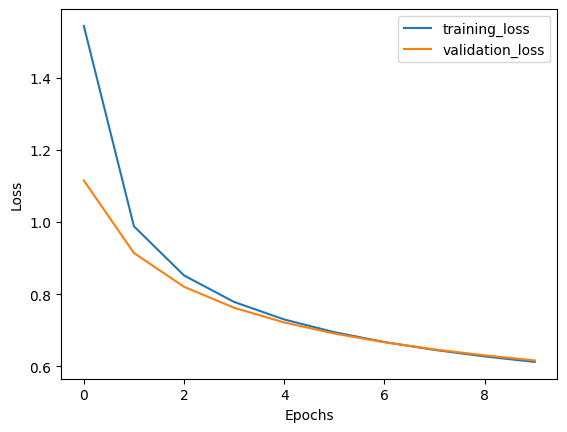

In [13]:
from torch.utils.data import DataLoader
batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
max_epochs = 10
learning_rate = 0.01
training_loss = []
validation_loss = []

for epoch in range(max_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0
    total = 0.0
    correct = 0.0
    roc_aucs = []
    y_pred = []
    y_true = []
    recalls = []
    for idx, data in enumerate(train_loader):
        features, labels = data

        # transfer to gpu, because model is on gpu
        features = features.cuda()
        labels = labels.cuda()

        # reshape 28x28 image features to single 784 row
        probs = model(features.reshape([-1, 784]))

        # calculate cross entropy loss : softmax is already applies on probs (output data), 
        # labels will have to be one-hot encoded
        loss = ce_loss(probs, labels)

        # keep track of training_loss for each iteration
        train_loss += loss.item()

        print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))
        # once loop is done, store per epoch training_loss to global list (take mean of iteration training loss)

    # zeroing out the grdients equiv to optimizer.zero_grad()
        for param in model.parameters():
            param.grad = None

    # backward pass
        loss.backward()

    # equiv to optimizer.step()
        for name, param in model.named_parameters():
          # Write paramtere update routine here:
          # --------------
            new_param = param - learning_rate * param.grad
          # --------------
            with torch.no_grad():
                param.copy_(new_param) # Copies the elements from src into self tensor and returns self.
        """
        The requires_grad argument tells PyTorch that we want to be able to calculate the gradients for those values. 
        However, the with torch.no_grad() tells PyTorch to not calculate the gradients, and the program explicitly 
        uses it here (as with most neural networks) in order to not update the gradients when it is updating the 
        weights as that would affect the back propagation.
        """
    training_loss.append(train_loss / len(train_loader))
    # metrics for validation set
# Write Validation routine here: 
    for idx, data in enumerate(valid_loader):
        features, labels = data
        features = features.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            probs = model(features.reshape([-1, 784]))

            loss = ce_loss(probs, labels)

            valid_loss += loss.item()

            # Getting the max probability class
            # Out of all (1024, 10) , pick the max from each of the 10 and flatten them to a single (1024) tensor
            mx_index = torch.argmax(probs, dim = 1)

            # prepare y_pred and y_true for metrics purpose (classification Report)
            y_pred = np.hstack((y_pred, mx_index.cpu()))
            y_true = np.hstack((y_true, labels.cpu()))

            # calc len of labels 
            total += labels.numel()

            # record correct labels (predict == true_label)
            correct += sum(mx_index == labels).item()
#             print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}:".format(epoch, max_epochs, idx, len(valid_loader), loss))
            roc_auc = roc_auc_score(labels.detach().cpu().numpy(), probs.detach().cpu().numpy(), multi_class='ovr')
            roc_aucs.append(roc_auc)
#             recall = recall_score(labels.cpu().numpy(), mx_index.cpu().numpy(), average='macro')
#             recalls.append(recall)
    validation_loss.append(valid_loss / len(valid_loader))
    accuracy = (correct / total) * 100
#                 print(f"Epoch {epoch + 1} Train Loss {train_loss / len(train_data)} Valid Loss {valid_loss / len(val_data)}\n")
#     auroc = AUROC(task="multiclass", num_classes=10)
    print(f"Accuracy : {accuracy} \n")
    print(f"SK LEARN Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Classification Report : \n {classification_report(y_true, y_pred, zero_division=1)} \n")
    print(f"F1_SCORE : {f1_score(y_true, y_pred, average='macro')}")
    print(f"Precision : {precision_score(y_true, y_pred, average='macro')}")
    print(f"Recall : {recall_score(y_true, y_pred, average='macro')}")
#     print(f"Recalls : {mean(recalls)}")
    print(f"ROCAUC : {sum(roc_aucs)/len(roc_aucs)}")
#     print(f"ROC_AUC : {auroc(np.array(y_pred_append_auroc), np.array(y_true_append_auroc))}")
#     auroc(y_pred, y_true)
print(training_loss)
plt.plot(training_loss, label='training_loss')
plt.plot(validation_loss, label='validation_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [15]:
def train(times):
    accuracy_over_trials = []
    f1_over_trials = []
    precision_over_trials = []
    recall_over_trials = []
    roc_auc_over_trials = []
    for i in range(times):
        print(f"Training Trial: {i+1}")
        seed = random.randint(1000,10000)
        random.seed(seed)
        torch.manual_seed(seed)
        batch_size = 1024
        model = NeuralNetwork().cuda()
        max_epochs = 10
        for epoch in range(max_epochs):
            train_loss = 0.0
            valid_loss = 0.0
            accuracy = 0.0
            for idx, data in enumerate(train_loader):
                features, labels = data
                
                # transfer to gpu, because model is on gpu
                features = features.cuda()
                labels = labels.cuda()
                
                # reshape 28x28 image features to single 784 row
                probs = model(features.reshape([-1, 784]))
                
                # calculate cross entropy loss : softmax is already applies on probs (output data), 
                # labels will have to be one-hot encoded
                loss = ce_loss(probs, labels)
                
                print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))
                # once loop is done, store per epoch training_loss to global list (take mean of iteration training loss)
    
            # zeroing out the grdients equiv to optimizer.zero_grad()
                for param in model.parameters():
                    param.grad = None
                    
            # backward pass
                loss.backward()
                
            # equiv to optimizer.step()
                for name, param in model.named_parameters():
                  # Write paramtere update routine here:
                  # --------------
                    new_param = param - learning_rate * param.grad
                  # --------------
                    with torch.no_grad():
                        param.copy_(new_param) # Copies the elements from src into self tensor and returns self.
        batch_size = 1024
        max_epochs = 10
        accuracy_over_epochs = []
        precision_over_epochs = []
        recall_over_epochs = []
        f1_over_epochs = []
        roc_curve_over_epochs = []

        total = 0
        correct = 0
        y_pred = []
        y_true = []
        roc_aucs = []
        for idx, data in enumerate(test_loader):
            features, labels = data
            features = features.cuda()
            labels = labels.cuda()

            with torch.no_grad():
                # model
                probs = model(features.reshape([-1, 784]))
                
                max_probab_vector = torch.argmax(probs, dim=1)
                
                y_pred = np.hstack((y_pred, max_probab_vector.cpu()))
                y_true = np.hstack((y_true, labels.cpu()))
                
                total += labels.numel()
                correct += sum(max_probab_vector == labels).item()
                
                roc_auc = roc_auc_score(labels.detach().cpu().numpy(), probs.detach().cpu().numpy(), multi_class='ovr')
                roc_aucs.append(roc_auc)
                
        print(f"Accuracy {(correct/total) * 100:.2f}")
        accuracy_over_trials.append((correct/total) * 100)
        f1_over_trials.append(f1_score(y_true, y_pred, average='macro'))
        precision_over_trials.append(precision_score(y_true, y_pred, average='macro', zero_division=1))
        recall_over_trials.append(recall_score(y_true, y_pred, average='macro'))
        roc_auc_over_trials.append(sum(roc_aucs)/len(roc_aucs))
    return accuracy_over_trials, f1_over_trials, precision_over_trials, recall_over_trials, roc_auc_over_trials

In [16]:
accuracy_over_trials, f1_over_trials, precision_over_trials, recall_over_trials, roc_over_trials = train(10)

Training Trial: 1
Epoch 0/10 Iteration 0/49 Loss 3.3737173080444336: 
Epoch 0/10 Iteration 1/49 Loss 2.9226694107055664: 
Epoch 0/10 Iteration 2/49 Loss 2.6497750282287598: 
Epoch 0/10 Iteration 3/49 Loss 2.418391466140747: 
Epoch 0/10 Iteration 4/49 Loss 2.3428850173950195: 
Epoch 0/10 Iteration 5/49 Loss 2.263697862625122: 
Epoch 0/10 Iteration 6/49 Loss 2.1451985836029053: 
Epoch 0/10 Iteration 7/49 Loss 2.046036720275879: 
Epoch 0/10 Iteration 8/49 Loss 1.9863550662994385: 
Epoch 0/10 Iteration 9/49 Loss 1.9790643453598022: 
Epoch 0/10 Iteration 10/49 Loss 1.8546907901763916: 
Epoch 0/10 Iteration 11/49 Loss 1.8327527046203613: 
Epoch 0/10 Iteration 12/49 Loss 1.7459731101989746: 
Epoch 0/10 Iteration 13/49 Loss 1.711317539215088: 
Epoch 0/10 Iteration 14/49 Loss 1.6993987560272217: 
Epoch 0/10 Iteration 15/49 Loss 1.6235905885696411: 
Epoch 0/10 Iteration 16/49 Loss 1.633044719696045: 
Epoch 0/10 Iteration 17/49 Loss 1.5868116617202759: 
Epoch 0/10 Iteration 18/49 Loss 1.567415118

Epoch 3/10 Iteration 10/49 Loss 0.7939358949661255: 
Epoch 3/10 Iteration 11/49 Loss 0.7635377049446106: 
Epoch 3/10 Iteration 12/49 Loss 0.7692669630050659: 
Epoch 3/10 Iteration 13/49 Loss 0.7959223985671997: 
Epoch 3/10 Iteration 14/49 Loss 0.773224413394928: 
Epoch 3/10 Iteration 15/49 Loss 0.7622318267822266: 
Epoch 3/10 Iteration 16/49 Loss 0.8004207611083984: 
Epoch 3/10 Iteration 17/49 Loss 0.7799209356307983: 
Epoch 3/10 Iteration 18/49 Loss 0.7926944494247437: 
Epoch 3/10 Iteration 19/49 Loss 0.772779107093811: 
Epoch 3/10 Iteration 20/49 Loss 0.8027870059013367: 
Epoch 3/10 Iteration 21/49 Loss 0.7661504149436951: 
Epoch 3/10 Iteration 22/49 Loss 0.7833055257797241: 
Epoch 3/10 Iteration 23/49 Loss 0.7761634588241577: 
Epoch 3/10 Iteration 24/49 Loss 0.8309910893440247: 
Epoch 3/10 Iteration 25/49 Loss 0.7593763470649719: 
Epoch 3/10 Iteration 26/49 Loss 0.7705481648445129: 
Epoch 3/10 Iteration 27/49 Loss 0.7542310953140259: 
Epoch 3/10 Iteration 28/49 Loss 0.75860053300857

Epoch 6/10 Iteration 19/49 Loss 0.6650968194007874: 
Epoch 6/10 Iteration 20/49 Loss 0.693536639213562: 
Epoch 6/10 Iteration 21/49 Loss 0.6490218639373779: 
Epoch 6/10 Iteration 22/49 Loss 0.6776756644248962: 
Epoch 6/10 Iteration 23/49 Loss 0.666950523853302: 
Epoch 6/10 Iteration 24/49 Loss 0.7338021993637085: 
Epoch 6/10 Iteration 25/49 Loss 0.656221866607666: 
Epoch 6/10 Iteration 26/49 Loss 0.6630704402923584: 
Epoch 6/10 Iteration 27/49 Loss 0.6557436585426331: 
Epoch 6/10 Iteration 28/49 Loss 0.6512258648872375: 
Epoch 6/10 Iteration 29/49 Loss 0.6977001428604126: 
Epoch 6/10 Iteration 30/49 Loss 0.6341454982757568: 
Epoch 6/10 Iteration 31/49 Loss 0.6487911939620972: 
Epoch 6/10 Iteration 32/49 Loss 0.6766508221626282: 
Epoch 6/10 Iteration 33/49 Loss 0.6823333501815796: 
Epoch 6/10 Iteration 34/49 Loss 0.6728962659835815: 
Epoch 6/10 Iteration 35/49 Loss 0.6435748338699341: 
Epoch 6/10 Iteration 36/49 Loss 0.6226084232330322: 
Epoch 6/10 Iteration 37/49 Loss 0.676824927330017

Epoch 9/10 Iteration 28/49 Loss 0.5981542468070984: 
Epoch 9/10 Iteration 29/49 Loss 0.645720362663269: 
Epoch 9/10 Iteration 30/49 Loss 0.587577223777771: 
Epoch 9/10 Iteration 31/49 Loss 0.5960472822189331: 
Epoch 9/10 Iteration 32/49 Loss 0.6276949644088745: 
Epoch 9/10 Iteration 33/49 Loss 0.631240963935852: 
Epoch 9/10 Iteration 34/49 Loss 0.6228233575820923: 
Epoch 9/10 Iteration 35/49 Loss 0.5948978066444397: 
Epoch 9/10 Iteration 36/49 Loss 0.5710623264312744: 
Epoch 9/10 Iteration 37/49 Loss 0.6293083429336548: 
Epoch 9/10 Iteration 38/49 Loss 0.582646906375885: 
Epoch 9/10 Iteration 39/49 Loss 0.6032605171203613: 
Epoch 9/10 Iteration 40/49 Loss 0.5681432485580444: 
Epoch 9/10 Iteration 41/49 Loss 0.5819931626319885: 
Epoch 9/10 Iteration 42/49 Loss 0.5875035524368286: 
Epoch 9/10 Iteration 43/49 Loss 0.5873783826828003: 
Epoch 9/10 Iteration 44/49 Loss 0.5973353981971741: 
Epoch 9/10 Iteration 45/49 Loss 0.6459535360336304: 
Epoch 9/10 Iteration 46/49 Loss 0.6453304290771484

Epoch 2/10 Iteration 38/49 Loss 0.8291791677474976: 
Epoch 2/10 Iteration 39/49 Loss 0.8198093175888062: 
Epoch 2/10 Iteration 40/49 Loss 0.7725015878677368: 
Epoch 2/10 Iteration 41/49 Loss 0.780187726020813: 
Epoch 2/10 Iteration 42/49 Loss 0.7985306978225708: 
Epoch 2/10 Iteration 43/49 Loss 0.7896847724914551: 
Epoch 2/10 Iteration 44/49 Loss 0.827828049659729: 
Epoch 2/10 Iteration 45/49 Loss 0.8844010829925537: 
Epoch 2/10 Iteration 46/49 Loss 0.8387867212295532: 
Epoch 2/10 Iteration 47/49 Loss 0.7734059691429138: 
Epoch 2/10 Iteration 48/49 Loss 0.8013388514518738: 
Epoch 3/10 Iteration 0/49 Loss 0.8370075821876526: 
Epoch 3/10 Iteration 1/49 Loss 0.8043860197067261: 
Epoch 3/10 Iteration 2/49 Loss 0.7795975208282471: 
Epoch 3/10 Iteration 3/49 Loss 0.7871659994125366: 
Epoch 3/10 Iteration 4/49 Loss 0.8257319927215576: 
Epoch 3/10 Iteration 5/49 Loss 0.817485511302948: 
Epoch 3/10 Iteration 6/49 Loss 0.7860175967216492: 
Epoch 3/10 Iteration 7/49 Loss 0.7504849433898926: 
Epoc

Epoch 6/10 Iteration 0/49 Loss 0.7132269144058228: 
Epoch 6/10 Iteration 1/49 Loss 0.6908190846443176: 
Epoch 6/10 Iteration 2/49 Loss 0.6645241975784302: 
Epoch 6/10 Iteration 3/49 Loss 0.6735250949859619: 
Epoch 6/10 Iteration 4/49 Loss 0.7056468725204468: 
Epoch 6/10 Iteration 5/49 Loss 0.6962605714797974: 
Epoch 6/10 Iteration 6/49 Loss 0.6684900522232056: 
Epoch 6/10 Iteration 7/49 Loss 0.6379740238189697: 
Epoch 6/10 Iteration 8/49 Loss 0.6681791543960571: 
Epoch 6/10 Iteration 9/49 Loss 0.6974242925643921: 
Epoch 6/10 Iteration 10/49 Loss 0.6808832883834839: 
Epoch 6/10 Iteration 11/49 Loss 0.6517953872680664: 
Epoch 6/10 Iteration 12/49 Loss 0.6689821481704712: 
Epoch 6/10 Iteration 13/49 Loss 0.6734527349472046: 
Epoch 6/10 Iteration 14/49 Loss 0.6619094014167786: 
Epoch 6/10 Iteration 15/49 Loss 0.6581557393074036: 
Epoch 6/10 Iteration 16/49 Loss 0.6927583813667297: 
Epoch 6/10 Iteration 17/49 Loss 0.66868656873703: 
Epoch 6/10 Iteration 18/49 Loss 0.672993540763855: 
Epoch 

Epoch 9/10 Iteration 11/49 Loss 0.5945579409599304: 
Epoch 9/10 Iteration 12/49 Loss 0.6072326898574829: 
Epoch 9/10 Iteration 13/49 Loss 0.6116055250167847: 
Epoch 9/10 Iteration 14/49 Loss 0.6054694652557373: 
Epoch 9/10 Iteration 15/49 Loss 0.606046736240387: 
Epoch 9/10 Iteration 16/49 Loss 0.6380521059036255: 
Epoch 9/10 Iteration 17/49 Loss 0.6130356788635254: 
Epoch 9/10 Iteration 18/49 Loss 0.6141842603683472: 
Epoch 9/10 Iteration 19/49 Loss 0.6237878799438477: 
Epoch 9/10 Iteration 20/49 Loss 0.6383957862854004: 
Epoch 9/10 Iteration 21/49 Loss 0.5977866649627686: 
Epoch 9/10 Iteration 22/49 Loss 0.6194144487380981: 
Epoch 9/10 Iteration 23/49 Loss 0.6170639395713806: 
Epoch 9/10 Iteration 24/49 Loss 0.701778769493103: 
Epoch 9/10 Iteration 25/49 Loss 0.6004836559295654: 
Epoch 9/10 Iteration 26/49 Loss 0.6012817621231079: 
Epoch 9/10 Iteration 27/49 Loss 0.61747145652771: 
Epoch 9/10 Iteration 28/49 Loss 0.6076139211654663: 
Epoch 9/10 Iteration 29/49 Loss 0.6500217914581299

Epoch 2/10 Iteration 20/49 Loss 0.8939532041549683: 
Epoch 2/10 Iteration 21/49 Loss 0.8425929546356201: 
Epoch 2/10 Iteration 22/49 Loss 0.8520945310592651: 
Epoch 2/10 Iteration 23/49 Loss 0.8674592971801758: 
Epoch 2/10 Iteration 24/49 Loss 0.9259842038154602: 
Epoch 2/10 Iteration 25/49 Loss 0.8653695583343506: 
Epoch 2/10 Iteration 26/49 Loss 0.8582684993743896: 
Epoch 2/10 Iteration 27/49 Loss 0.858751118183136: 
Epoch 2/10 Iteration 28/49 Loss 0.8436280488967896: 
Epoch 2/10 Iteration 29/49 Loss 0.9156516790390015: 
Epoch 2/10 Iteration 30/49 Loss 0.8227419853210449: 
Epoch 2/10 Iteration 31/49 Loss 0.8102859258651733: 
Epoch 2/10 Iteration 32/49 Loss 0.8714218139648438: 
Epoch 2/10 Iteration 33/49 Loss 0.899459958076477: 
Epoch 2/10 Iteration 34/49 Loss 0.8672541379928589: 
Epoch 2/10 Iteration 35/49 Loss 0.8382987976074219: 
Epoch 2/10 Iteration 36/49 Loss 0.8063912987709045: 
Epoch 2/10 Iteration 37/49 Loss 0.8568130731582642: 
Epoch 2/10 Iteration 38/49 Loss 0.83004468679428

Epoch 5/10 Iteration 31/49 Loss 0.6645505428314209: 
Epoch 5/10 Iteration 32/49 Loss 0.7271603345870972: 
Epoch 5/10 Iteration 33/49 Loss 0.7451626062393188: 
Epoch 5/10 Iteration 34/49 Loss 0.7146127223968506: 
Epoch 5/10 Iteration 35/49 Loss 0.6889732480049133: 
Epoch 5/10 Iteration 36/49 Loss 0.6560758352279663: 
Epoch 5/10 Iteration 37/49 Loss 0.7181618213653564: 
Epoch 5/10 Iteration 38/49 Loss 0.6776595115661621: 
Epoch 5/10 Iteration 39/49 Loss 0.6722956895828247: 
Epoch 5/10 Iteration 40/49 Loss 0.6361933946609497: 
Epoch 5/10 Iteration 41/49 Loss 0.635866105556488: 
Epoch 5/10 Iteration 42/49 Loss 0.6660611629486084: 
Epoch 5/10 Iteration 43/49 Loss 0.6839208006858826: 
Epoch 5/10 Iteration 44/49 Loss 0.6981236934661865: 
Epoch 5/10 Iteration 45/49 Loss 0.7619471549987793: 
Epoch 5/10 Iteration 46/49 Loss 0.7208809852600098: 
Epoch 5/10 Iteration 47/49 Loss 0.6766160726547241: 
Epoch 5/10 Iteration 48/49 Loss 0.6830041408538818: 
Epoch 6/10 Iteration 0/49 Loss 0.70584869384765

Epoch 8/10 Iteration 40/49 Loss 0.570327639579773: 
Epoch 8/10 Iteration 41/49 Loss 0.5773422718048096: 
Epoch 8/10 Iteration 42/49 Loss 0.5982552766799927: 
Epoch 8/10 Iteration 43/49 Loss 0.6154376268386841: 
Epoch 8/10 Iteration 44/49 Loss 0.6343933343887329: 
Epoch 8/10 Iteration 45/49 Loss 0.6935628056526184: 
Epoch 8/10 Iteration 46/49 Loss 0.6560356616973877: 
Epoch 8/10 Iteration 47/49 Loss 0.6091382503509521: 
Epoch 8/10 Iteration 48/49 Loss 0.6189648509025574: 
Epoch 9/10 Iteration 0/49 Loss 0.6453578472137451: 
Epoch 9/10 Iteration 1/49 Loss 0.6538712978363037: 
Epoch 9/10 Iteration 2/49 Loss 0.6205000281333923: 
Epoch 9/10 Iteration 3/49 Loss 0.652538537979126: 
Epoch 9/10 Iteration 4/49 Loss 0.6360146999359131: 
Epoch 9/10 Iteration 5/49 Loss 0.6406869888305664: 
Epoch 9/10 Iteration 6/49 Loss 0.6076633930206299: 
Epoch 9/10 Iteration 7/49 Loss 0.6122665405273438: 
Epoch 9/10 Iteration 8/49 Loss 0.6075361371040344: 
Epoch 9/10 Iteration 9/49 Loss 0.6206843852996826: 
Epoch

Epoch 2/10 Iteration 0/49 Loss 0.9362889528274536: 
Epoch 2/10 Iteration 1/49 Loss 0.9367530345916748: 
Epoch 2/10 Iteration 2/49 Loss 0.8755929470062256: 
Epoch 2/10 Iteration 3/49 Loss 0.9211380481719971: 
Epoch 2/10 Iteration 4/49 Loss 0.9287009239196777: 
Epoch 2/10 Iteration 5/49 Loss 0.9345715045928955: 
Epoch 2/10 Iteration 6/49 Loss 0.8568991422653198: 
Epoch 2/10 Iteration 7/49 Loss 0.8530771732330322: 
Epoch 2/10 Iteration 8/49 Loss 0.9102840423583984: 
Epoch 2/10 Iteration 9/49 Loss 0.9075125455856323: 
Epoch 2/10 Iteration 10/49 Loss 0.8974188566207886: 
Epoch 2/10 Iteration 11/49 Loss 0.8813661336898804: 
Epoch 2/10 Iteration 12/49 Loss 0.8904407620429993: 
Epoch 2/10 Iteration 13/49 Loss 0.9363685846328735: 
Epoch 2/10 Iteration 14/49 Loss 0.8673820495605469: 
Epoch 2/10 Iteration 15/49 Loss 0.8652730584144592: 
Epoch 2/10 Iteration 16/49 Loss 0.9031188488006592: 
Epoch 2/10 Iteration 17/49 Loss 0.858599841594696: 
Epoch 2/10 Iteration 18/49 Loss 0.8566434383392334: 
Epoc

Epoch 5/10 Iteration 9/49 Loss 0.7212779521942139: 
Epoch 5/10 Iteration 10/49 Loss 0.7251786589622498: 
Epoch 5/10 Iteration 11/49 Loss 0.7071611881256104: 
Epoch 5/10 Iteration 12/49 Loss 0.7112953066825867: 
Epoch 5/10 Iteration 13/49 Loss 0.7535471320152283: 
Epoch 5/10 Iteration 14/49 Loss 0.6963849067687988: 
Epoch 5/10 Iteration 15/49 Loss 0.7000633478164673: 
Epoch 5/10 Iteration 16/49 Loss 0.7440224885940552: 
Epoch 5/10 Iteration 17/49 Loss 0.6969060897827148: 
Epoch 5/10 Iteration 18/49 Loss 0.6947557330131531: 
Epoch 5/10 Iteration 19/49 Loss 0.7083457708358765: 
Epoch 5/10 Iteration 20/49 Loss 0.7447221875190735: 
Epoch 5/10 Iteration 21/49 Loss 0.6751009225845337: 
Epoch 5/10 Iteration 22/49 Loss 0.7320395708084106: 
Epoch 5/10 Iteration 23/49 Loss 0.7233080863952637: 
Epoch 5/10 Iteration 24/49 Loss 0.7626967430114746: 
Epoch 5/10 Iteration 25/49 Loss 0.6805461645126343: 
Epoch 5/10 Iteration 26/49 Loss 0.7031814455986023: 
Epoch 5/10 Iteration 27/49 Loss 0.7103025317192

Epoch 8/10 Iteration 19/49 Loss 0.639656662940979: 
Epoch 8/10 Iteration 20/49 Loss 0.67605060338974: 
Epoch 8/10 Iteration 21/49 Loss 0.6032395362854004: 
Epoch 8/10 Iteration 22/49 Loss 0.6673500537872314: 
Epoch 8/10 Iteration 23/49 Loss 0.6537870168685913: 
Epoch 8/10 Iteration 24/49 Loss 0.7010459899902344: 
Epoch 8/10 Iteration 25/49 Loss 0.6169928312301636: 
Epoch 8/10 Iteration 26/49 Loss 0.6364531517028809: 
Epoch 8/10 Iteration 27/49 Loss 0.6483856439590454: 
Epoch 8/10 Iteration 28/49 Loss 0.6237326860427856: 
Epoch 8/10 Iteration 29/49 Loss 0.6691473722457886: 
Epoch 8/10 Iteration 30/49 Loss 0.6171860694885254: 
Epoch 8/10 Iteration 31/49 Loss 0.6001967191696167: 
Epoch 8/10 Iteration 32/49 Loss 0.6570488214492798: 
Epoch 8/10 Iteration 33/49 Loss 0.6553168892860413: 
Epoch 8/10 Iteration 34/49 Loss 0.6147748231887817: 
Epoch 8/10 Iteration 35/49 Loss 0.6055558919906616: 
Epoch 8/10 Iteration 36/49 Loss 0.6007448434829712: 
Epoch 8/10 Iteration 37/49 Loss 0.652311444282531

Epoch 1/10 Iteration 29/49 Loss 1.0358500480651855: 
Epoch 1/10 Iteration 30/49 Loss 0.9859355092048645: 
Epoch 1/10 Iteration 31/49 Loss 0.9553239345550537: 
Epoch 1/10 Iteration 32/49 Loss 0.9825196266174316: 
Epoch 1/10 Iteration 33/49 Loss 0.9988973140716553: 
Epoch 1/10 Iteration 34/49 Loss 0.9565777778625488: 
Epoch 1/10 Iteration 35/49 Loss 0.9573509097099304: 
Epoch 1/10 Iteration 36/49 Loss 0.952367901802063: 
Epoch 1/10 Iteration 37/49 Loss 0.9594836831092834: 
Epoch 1/10 Iteration 38/49 Loss 0.9828696846961975: 
Epoch 1/10 Iteration 39/49 Loss 0.9579007625579834: 
Epoch 1/10 Iteration 40/49 Loss 0.8941159248352051: 
Epoch 1/10 Iteration 41/49 Loss 0.8926066160202026: 
Epoch 1/10 Iteration 42/49 Loss 0.9289888143539429: 
Epoch 1/10 Iteration 43/49 Loss 0.9195650815963745: 
Epoch 1/10 Iteration 44/49 Loss 0.9372760057449341: 
Epoch 1/10 Iteration 45/49 Loss 0.9894789457321167: 
Epoch 1/10 Iteration 46/49 Loss 0.9695253372192383: 
Epoch 1/10 Iteration 47/49 Loss 0.8837572336196

Epoch 4/10 Iteration 39/49 Loss 0.7188189029693604: 
Epoch 4/10 Iteration 40/49 Loss 0.6702344417572021: 
Epoch 4/10 Iteration 41/49 Loss 0.6780345439910889: 
Epoch 4/10 Iteration 42/49 Loss 0.7048642635345459: 
Epoch 4/10 Iteration 43/49 Loss 0.6961775422096252: 
Epoch 4/10 Iteration 44/49 Loss 0.7231648564338684: 
Epoch 4/10 Iteration 45/49 Loss 0.7745532989501953: 
Epoch 4/10 Iteration 46/49 Loss 0.7650916576385498: 
Epoch 4/10 Iteration 47/49 Loss 0.6792066097259521: 
Epoch 4/10 Iteration 48/49 Loss 0.7278954982757568: 
Epoch 5/10 Iteration 0/49 Loss 0.7521815896034241: 
Epoch 5/10 Iteration 1/49 Loss 0.7288628220558167: 
Epoch 5/10 Iteration 2/49 Loss 0.6889642477035522: 
Epoch 5/10 Iteration 3/49 Loss 0.7308236956596375: 
Epoch 5/10 Iteration 4/49 Loss 0.7259070873260498: 
Epoch 5/10 Iteration 5/49 Loss 0.7410561442375183: 
Epoch 5/10 Iteration 6/49 Loss 0.6898260116577148: 
Epoch 5/10 Iteration 7/49 Loss 0.694541335105896: 
Epoch 5/10 Iteration 8/49 Loss 0.702485978603363: 
Epoc

Epoch 7/10 Iteration 48/49 Loss 0.6475622653961182: 
Epoch 8/10 Iteration 0/49 Loss 0.6743911504745483: 
Epoch 8/10 Iteration 1/49 Loss 0.6560558080673218: 
Epoch 8/10 Iteration 2/49 Loss 0.6160106062889099: 
Epoch 8/10 Iteration 3/49 Loss 0.6605781316757202: 
Epoch 8/10 Iteration 4/49 Loss 0.6551657319068909: 
Epoch 8/10 Iteration 5/49 Loss 0.6664319038391113: 
Epoch 8/10 Iteration 6/49 Loss 0.6201950907707214: 
Epoch 8/10 Iteration 7/49 Loss 0.6220979690551758: 
Epoch 8/10 Iteration 8/49 Loss 0.6224281191825867: 
Epoch 8/10 Iteration 9/49 Loss 0.6384232044219971: 
Epoch 8/10 Iteration 10/49 Loss 0.643693745136261: 
Epoch 8/10 Iteration 11/49 Loss 0.6206115484237671: 
Epoch 8/10 Iteration 12/49 Loss 0.6438235640525818: 
Epoch 8/10 Iteration 13/49 Loss 0.6457467675209045: 
Epoch 8/10 Iteration 14/49 Loss 0.6272308826446533: 
Epoch 8/10 Iteration 15/49 Loss 0.6104754209518433: 
Epoch 8/10 Iteration 16/49 Loss 0.6540259122848511: 
Epoch 8/10 Iteration 17/49 Loss 0.6145275831222534: 
Epoc

Epoch 1/10 Iteration 10/49 Loss 1.0347177982330322: 
Epoch 1/10 Iteration 11/49 Loss 0.9922083616256714: 
Epoch 1/10 Iteration 12/49 Loss 1.0017342567443848: 
Epoch 1/10 Iteration 13/49 Loss 1.023194670677185: 
Epoch 1/10 Iteration 14/49 Loss 1.036037802696228: 
Epoch 1/10 Iteration 15/49 Loss 0.9619762897491455: 
Epoch 1/10 Iteration 16/49 Loss 0.9708471298217773: 
Epoch 1/10 Iteration 17/49 Loss 0.9745264053344727: 
Epoch 1/10 Iteration 18/49 Loss 0.9992573261260986: 
Epoch 1/10 Iteration 19/49 Loss 0.965298056602478: 
Epoch 1/10 Iteration 20/49 Loss 0.9693056344985962: 
Epoch 1/10 Iteration 21/49 Loss 0.9500048160552979: 
Epoch 1/10 Iteration 22/49 Loss 0.9851047992706299: 
Epoch 1/10 Iteration 23/49 Loss 0.9845318794250488: 
Epoch 1/10 Iteration 24/49 Loss 0.9876739382743835: 
Epoch 1/10 Iteration 25/49 Loss 0.9298049211502075: 
Epoch 1/10 Iteration 26/49 Loss 0.9497018456459045: 
Epoch 1/10 Iteration 27/49 Loss 0.948018491268158: 
Epoch 1/10 Iteration 28/49 Loss 0.9473719596862793

Epoch 4/10 Iteration 21/49 Loss 0.6950491666793823: 
Epoch 4/10 Iteration 22/49 Loss 0.7425965070724487: 
Epoch 4/10 Iteration 23/49 Loss 0.7390366792678833: 
Epoch 4/10 Iteration 24/49 Loss 0.7692265510559082: 
Epoch 4/10 Iteration 25/49 Loss 0.7084335088729858: 
Epoch 4/10 Iteration 26/49 Loss 0.7302717566490173: 
Epoch 4/10 Iteration 27/49 Loss 0.7272261381149292: 
Epoch 4/10 Iteration 28/49 Loss 0.7209454774856567: 
Epoch 4/10 Iteration 29/49 Loss 0.7636098861694336: 
Epoch 4/10 Iteration 30/49 Loss 0.7070516347885132: 
Epoch 4/10 Iteration 31/49 Loss 0.6969120502471924: 
Epoch 4/10 Iteration 32/49 Loss 0.7175359725952148: 
Epoch 4/10 Iteration 33/49 Loss 0.7611870765686035: 
Epoch 4/10 Iteration 34/49 Loss 0.7215566635131836: 
Epoch 4/10 Iteration 35/49 Loss 0.7140940427780151: 
Epoch 4/10 Iteration 36/49 Loss 0.6994825601577759: 
Epoch 4/10 Iteration 37/49 Loss 0.7250460386276245: 
Epoch 4/10 Iteration 38/49 Loss 0.7124714851379395: 
Epoch 4/10 Iteration 39/49 Loss 0.713804364204

Epoch 7/10 Iteration 32/49 Loss 0.6479749083518982: 
Epoch 7/10 Iteration 33/49 Loss 0.6862345933914185: 
Epoch 7/10 Iteration 34/49 Loss 0.6501495838165283: 
Epoch 7/10 Iteration 35/49 Loss 0.6415489912033081: 
Epoch 7/10 Iteration 36/49 Loss 0.6223487257957458: 
Epoch 7/10 Iteration 37/49 Loss 0.6563953161239624: 
Epoch 7/10 Iteration 38/49 Loss 0.6375789642333984: 
Epoch 7/10 Iteration 39/49 Loss 0.6376944780349731: 
Epoch 7/10 Iteration 40/49 Loss 0.6032004356384277: 
Epoch 7/10 Iteration 41/49 Loss 0.5969355702400208: 
Epoch 7/10 Iteration 42/49 Loss 0.6246310472488403: 
Epoch 7/10 Iteration 43/49 Loss 0.6056293249130249: 
Epoch 7/10 Iteration 44/49 Loss 0.6335735321044922: 
Epoch 7/10 Iteration 45/49 Loss 0.6867885589599609: 
Epoch 7/10 Iteration 46/49 Loss 0.6790729761123657: 
Epoch 7/10 Iteration 47/49 Loss 0.6218396425247192: 
Epoch 7/10 Iteration 48/49 Loss 0.6420969367027283: 
Epoch 8/10 Iteration 0/49 Loss 0.6550459265708923: 
Epoch 8/10 Iteration 1/49 Loss 0.6529541015625:

Epoch 0/10 Iteration 41/49 Loss 1.1785894632339478: 
Epoch 0/10 Iteration 42/49 Loss 1.1947252750396729: 
Epoch 0/10 Iteration 43/49 Loss 1.2261749505996704: 
Epoch 0/10 Iteration 44/49 Loss 1.1875824928283691: 
Epoch 0/10 Iteration 45/49 Loss 1.2495020627975464: 
Epoch 0/10 Iteration 46/49 Loss 1.2117712497711182: 
Epoch 0/10 Iteration 47/49 Loss 1.1814286708831787: 
Epoch 0/10 Iteration 48/49 Loss 1.1883697509765625: 
Epoch 1/10 Iteration 0/49 Loss 1.1746091842651367: 
Epoch 1/10 Iteration 1/49 Loss 1.172609806060791: 
Epoch 1/10 Iteration 2/49 Loss 1.1152544021606445: 
Epoch 1/10 Iteration 3/49 Loss 1.1265246868133545: 
Epoch 1/10 Iteration 4/49 Loss 1.141578197479248: 
Epoch 1/10 Iteration 5/49 Loss 1.145090103149414: 
Epoch 1/10 Iteration 6/49 Loss 1.0797450542449951: 
Epoch 1/10 Iteration 7/49 Loss 1.0956608057022095: 
Epoch 1/10 Iteration 8/49 Loss 1.109376311302185: 
Epoch 1/10 Iteration 9/49 Loss 1.1348007917404175: 
Epoch 1/10 Iteration 10/49 Loss 1.0967307090759277: 
Epoch 1

Epoch 4/10 Iteration 1/49 Loss 0.7922192811965942: 
Epoch 4/10 Iteration 2/49 Loss 0.7398650646209717: 
Epoch 4/10 Iteration 3/49 Loss 0.7719972729682922: 
Epoch 4/10 Iteration 4/49 Loss 0.7892764210700989: 
Epoch 4/10 Iteration 5/49 Loss 0.7998459339141846: 
Epoch 4/10 Iteration 6/49 Loss 0.7364344596862793: 
Epoch 4/10 Iteration 7/49 Loss 0.7536871433258057: 
Epoch 4/10 Iteration 8/49 Loss 0.7574541568756104: 
Epoch 4/10 Iteration 9/49 Loss 0.7932798266410828: 
Epoch 4/10 Iteration 10/49 Loss 0.7746740579605103: 
Epoch 4/10 Iteration 11/49 Loss 0.7352888584136963: 
Epoch 4/10 Iteration 12/49 Loss 0.7526500225067139: 
Epoch 4/10 Iteration 13/49 Loss 0.7739940285682678: 
Epoch 4/10 Iteration 14/49 Loss 0.7256155610084534: 
Epoch 4/10 Iteration 15/49 Loss 0.7355740666389465: 
Epoch 4/10 Iteration 16/49 Loss 0.7560532093048096: 
Epoch 4/10 Iteration 17/49 Loss 0.7459395527839661: 
Epoch 4/10 Iteration 18/49 Loss 0.7477945685386658: 
Epoch 4/10 Iteration 19/49 Loss 0.7153183817863464: 
Ep

Epoch 7/10 Iteration 10/49 Loss 0.6814757585525513: 
Epoch 7/10 Iteration 11/49 Loss 0.6446426510810852: 
Epoch 7/10 Iteration 12/49 Loss 0.6563684940338135: 
Epoch 7/10 Iteration 13/49 Loss 0.6766146421432495: 
Epoch 7/10 Iteration 14/49 Loss 0.631024181842804: 
Epoch 7/10 Iteration 15/49 Loss 0.6503767371177673: 
Epoch 7/10 Iteration 16/49 Loss 0.6703197956085205: 
Epoch 7/10 Iteration 17/49 Loss 0.6563042402267456: 
Epoch 7/10 Iteration 18/49 Loss 0.6570073366165161: 
Epoch 7/10 Iteration 19/49 Loss 0.6296840906143188: 
Epoch 7/10 Iteration 20/49 Loss 0.6813504099845886: 
Epoch 7/10 Iteration 21/49 Loss 0.6261828541755676: 
Epoch 7/10 Iteration 22/49 Loss 0.6643942594528198: 
Epoch 7/10 Iteration 23/49 Loss 0.6590573191642761: 
Epoch 7/10 Iteration 24/49 Loss 0.714637815952301: 
Epoch 7/10 Iteration 25/49 Loss 0.6603596210479736: 
Epoch 7/10 Iteration 26/49 Loss 0.6563438177108765: 
Epoch 7/10 Iteration 27/49 Loss 0.6808061599731445: 
Epoch 7/10 Iteration 28/49 Loss 0.63947445154190

Epoch 0/10 Iteration 20/49 Loss 1.5812550783157349: 
Epoch 0/10 Iteration 21/49 Loss 1.5228960514068604: 
Epoch 0/10 Iteration 22/49 Loss 1.4825897216796875: 
Epoch 0/10 Iteration 23/49 Loss 1.4909117221832275: 
Epoch 0/10 Iteration 24/49 Loss 1.5061109066009521: 
Epoch 0/10 Iteration 25/49 Loss 1.4240883588790894: 
Epoch 0/10 Iteration 26/49 Loss 1.4318288564682007: 
Epoch 0/10 Iteration 27/49 Loss 1.3872027397155762: 
Epoch 0/10 Iteration 28/49 Loss 1.404756784439087: 
Epoch 0/10 Iteration 29/49 Loss 1.4236478805541992: 
Epoch 0/10 Iteration 30/49 Loss 1.3497531414031982: 
Epoch 0/10 Iteration 31/49 Loss 1.320816993713379: 
Epoch 0/10 Iteration 32/49 Loss 1.3381855487823486: 
Epoch 0/10 Iteration 33/49 Loss 1.3349108695983887: 
Epoch 0/10 Iteration 34/49 Loss 1.3218779563903809: 
Epoch 0/10 Iteration 35/49 Loss 1.2679152488708496: 
Epoch 0/10 Iteration 36/49 Loss 1.2532434463500977: 
Epoch 0/10 Iteration 37/49 Loss 1.2733924388885498: 
Epoch 0/10 Iteration 38/49 Loss 1.25545108318328

Epoch 3/10 Iteration 31/49 Loss 0.7622921466827393: 
Epoch 3/10 Iteration 32/49 Loss 0.8109909296035767: 
Epoch 3/10 Iteration 33/49 Loss 0.8244116306304932: 
Epoch 3/10 Iteration 34/49 Loss 0.8006584644317627: 
Epoch 3/10 Iteration 35/49 Loss 0.766742467880249: 
Epoch 3/10 Iteration 36/49 Loss 0.7642902135848999: 
Epoch 3/10 Iteration 37/49 Loss 0.7993584871292114: 
Epoch 3/10 Iteration 38/49 Loss 0.790855884552002: 
Epoch 3/10 Iteration 39/49 Loss 0.764142632484436: 
Epoch 3/10 Iteration 40/49 Loss 0.7351519465446472: 
Epoch 3/10 Iteration 41/49 Loss 0.7449374794960022: 
Epoch 3/10 Iteration 42/49 Loss 0.7853620052337646: 
Epoch 3/10 Iteration 43/49 Loss 0.7657641172409058: 
Epoch 3/10 Iteration 44/49 Loss 0.7824274301528931: 
Epoch 3/10 Iteration 45/49 Loss 0.8361586332321167: 
Epoch 3/10 Iteration 46/49 Loss 0.8179820775985718: 
Epoch 3/10 Iteration 47/49 Loss 0.766338586807251: 
Epoch 3/10 Iteration 48/49 Loss 0.807348370552063: 
Epoch 4/10 Iteration 0/49 Loss 0.8067161440849304: 

Epoch 6/10 Iteration 40/49 Loss 0.6268215775489807: 
Epoch 6/10 Iteration 41/49 Loss 0.6427332162857056: 
Epoch 6/10 Iteration 42/49 Loss 0.6762002110481262: 
Epoch 6/10 Iteration 43/49 Loss 0.655359148979187: 
Epoch 6/10 Iteration 44/49 Loss 0.6779557466506958: 
Epoch 6/10 Iteration 45/49 Loss 0.7300772666931152: 
Epoch 6/10 Iteration 46/49 Loss 0.7161319255828857: 
Epoch 6/10 Iteration 47/49 Loss 0.6592423915863037: 
Epoch 6/10 Iteration 48/49 Loss 0.6985697150230408: 
Epoch 7/10 Iteration 0/49 Loss 0.7036134004592896: 
Epoch 7/10 Iteration 1/49 Loss 0.6955476999282837: 
Epoch 7/10 Iteration 2/49 Loss 0.6627649664878845: 
Epoch 7/10 Iteration 3/49 Loss 0.6924347281455994: 
Epoch 7/10 Iteration 4/49 Loss 0.6892634034156799: 
Epoch 7/10 Iteration 5/49 Loss 0.7025703191757202: 
Epoch 7/10 Iteration 6/49 Loss 0.6533521413803101: 
Epoch 7/10 Iteration 7/49 Loss 0.639581561088562: 
Epoch 7/10 Iteration 8/49 Loss 0.6731139421463013: 
Epoch 7/10 Iteration 9/49 Loss 0.6853480339050293: 
Epoch

Accuracy 78.27
Training Trial: 9
Epoch 0/10 Iteration 0/49 Loss 3.2134335041046143: 
Epoch 0/10 Iteration 1/49 Loss 2.763319730758667: 
Epoch 0/10 Iteration 2/49 Loss 2.518951416015625: 
Epoch 0/10 Iteration 3/49 Loss 2.278590679168701: 
Epoch 0/10 Iteration 4/49 Loss 2.1524276733398438: 
Epoch 0/10 Iteration 5/49 Loss 2.143484115600586: 
Epoch 0/10 Iteration 6/49 Loss 2.0719759464263916: 
Epoch 0/10 Iteration 7/49 Loss 1.9539141654968262: 
Epoch 0/10 Iteration 8/49 Loss 1.9348673820495605: 
Epoch 0/10 Iteration 9/49 Loss 1.9098789691925049: 
Epoch 0/10 Iteration 10/49 Loss 1.8500397205352783: 
Epoch 0/10 Iteration 11/49 Loss 1.7300117015838623: 
Epoch 0/10 Iteration 12/49 Loss 1.772637128829956: 
Epoch 0/10 Iteration 13/49 Loss 1.7524266242980957: 
Epoch 0/10 Iteration 14/49 Loss 1.7019076347351074: 
Epoch 0/10 Iteration 15/49 Loss 1.6018904447555542: 
Epoch 0/10 Iteration 16/49 Loss 1.5790038108825684: 
Epoch 0/10 Iteration 17/49 Loss 1.5746384859085083: 
Epoch 0/10 Iteration 18/49 L

Epoch 3/10 Iteration 10/49 Loss 0.8193545937538147: 
Epoch 3/10 Iteration 11/49 Loss 0.7647454142570496: 
Epoch 3/10 Iteration 12/49 Loss 0.785703718662262: 
Epoch 3/10 Iteration 13/49 Loss 0.8141348958015442: 
Epoch 3/10 Iteration 14/49 Loss 0.7902016043663025: 
Epoch 3/10 Iteration 15/49 Loss 0.7487015128135681: 
Epoch 3/10 Iteration 16/49 Loss 0.7845256328582764: 
Epoch 3/10 Iteration 17/49 Loss 0.762479305267334: 
Epoch 3/10 Iteration 18/49 Loss 0.7825599908828735: 
Epoch 3/10 Iteration 19/49 Loss 0.7599245309829712: 
Epoch 3/10 Iteration 20/49 Loss 0.807275652885437: 
Epoch 3/10 Iteration 21/49 Loss 0.7480579614639282: 
Epoch 3/10 Iteration 22/49 Loss 0.7449455857276917: 
Epoch 3/10 Iteration 23/49 Loss 0.7763161063194275: 
Epoch 3/10 Iteration 24/49 Loss 0.8413013815879822: 
Epoch 3/10 Iteration 25/49 Loss 0.7771137952804565: 
Epoch 3/10 Iteration 26/49 Loss 0.7668217420578003: 
Epoch 3/10 Iteration 27/49 Loss 0.7818481922149658: 
Epoch 3/10 Iteration 28/49 Loss 0.762758135795593

Epoch 6/10 Iteration 21/49 Loss 0.6335400342941284: 
Epoch 6/10 Iteration 22/49 Loss 0.6485081911087036: 
Epoch 6/10 Iteration 23/49 Loss 0.6671510934829712: 
Epoch 6/10 Iteration 24/49 Loss 0.7346202731132507: 
Epoch 6/10 Iteration 25/49 Loss 0.6733945608139038: 
Epoch 6/10 Iteration 26/49 Loss 0.6613994836807251: 
Epoch 6/10 Iteration 27/49 Loss 0.6771400570869446: 
Epoch 6/10 Iteration 28/49 Loss 0.651797890663147: 
Epoch 6/10 Iteration 29/49 Loss 0.702896237373352: 
Epoch 6/10 Iteration 30/49 Loss 0.6486597061157227: 
Epoch 6/10 Iteration 31/49 Loss 0.6433573961257935: 
Epoch 6/10 Iteration 32/49 Loss 0.6915280222892761: 
Epoch 6/10 Iteration 33/49 Loss 0.6863094568252563: 
Epoch 6/10 Iteration 34/49 Loss 0.6655575037002563: 
Epoch 6/10 Iteration 35/49 Loss 0.6399787068367004: 
Epoch 6/10 Iteration 36/49 Loss 0.6119847297668457: 
Epoch 6/10 Iteration 37/49 Loss 0.6765966415405273: 
Epoch 6/10 Iteration 38/49 Loss 0.628753125667572: 
Epoch 6/10 Iteration 39/49 Loss 0.643546104431152

Epoch 9/10 Iteration 30/49 Loss 0.5990650653839111: 
Epoch 9/10 Iteration 31/49 Loss 0.5904357433319092: 
Epoch 9/10 Iteration 32/49 Loss 0.6401149034500122: 
Epoch 9/10 Iteration 33/49 Loss 0.6342422962188721: 
Epoch 9/10 Iteration 34/49 Loss 0.6139148473739624: 
Epoch 9/10 Iteration 35/49 Loss 0.5885592699050903: 
Epoch 9/10 Iteration 36/49 Loss 0.5636454820632935: 
Epoch 9/10 Iteration 37/49 Loss 0.6278288960456848: 
Epoch 9/10 Iteration 38/49 Loss 0.5776789784431458: 
Epoch 9/10 Iteration 39/49 Loss 0.5922112464904785: 
Epoch 9/10 Iteration 40/49 Loss 0.5529595613479614: 
Epoch 9/10 Iteration 41/49 Loss 0.5700485706329346: 
Epoch 9/10 Iteration 42/49 Loss 0.5758112668991089: 
Epoch 9/10 Iteration 43/49 Loss 0.5705285668373108: 
Epoch 9/10 Iteration 44/49 Loss 0.5982003211975098: 
Epoch 9/10 Iteration 45/49 Loss 0.6621962785720825: 
Epoch 9/10 Iteration 46/49 Loss 0.6366898417472839: 
Epoch 9/10 Iteration 47/49 Loss 0.5788047313690186: 
Epoch 9/10 Iteration 48/49 Loss 0.613398194313

Epoch 2/10 Iteration 39/49 Loss 0.8190808296203613: 
Epoch 2/10 Iteration 40/49 Loss 0.7479391098022461: 
Epoch 2/10 Iteration 41/49 Loss 0.7689551711082458: 
Epoch 2/10 Iteration 42/49 Loss 0.7915486097335815: 
Epoch 2/10 Iteration 43/49 Loss 0.7907565832138062: 
Epoch 2/10 Iteration 44/49 Loss 0.7957009673118591: 
Epoch 2/10 Iteration 45/49 Loss 0.8587329387664795: 
Epoch 2/10 Iteration 46/49 Loss 0.8520134687423706: 
Epoch 2/10 Iteration 47/49 Loss 0.7488909363746643: 
Epoch 2/10 Iteration 48/49 Loss 0.8026660680770874: 
Epoch 3/10 Iteration 0/49 Loss 0.8103187084197998: 
Epoch 3/10 Iteration 1/49 Loss 0.8166065812110901: 
Epoch 3/10 Iteration 2/49 Loss 0.7618200778961182: 
Epoch 3/10 Iteration 3/49 Loss 0.7988806962966919: 
Epoch 3/10 Iteration 4/49 Loss 0.7945802211761475: 
Epoch 3/10 Iteration 5/49 Loss 0.8275119066238403: 
Epoch 3/10 Iteration 6/49 Loss 0.7818893194198608: 
Epoch 3/10 Iteration 7/49 Loss 0.7612661719322205: 
Epoch 3/10 Iteration 8/49 Loss 0.7778860330581665: 
Ep

Epoch 5/10 Iteration 48/49 Loss 0.675521731376648: 
Epoch 6/10 Iteration 0/49 Loss 0.6903178691864014: 
Epoch 6/10 Iteration 1/49 Loss 0.7005469799041748: 
Epoch 6/10 Iteration 2/49 Loss 0.6433864831924438: 
Epoch 6/10 Iteration 3/49 Loss 0.6878155469894409: 
Epoch 6/10 Iteration 4/49 Loss 0.68439781665802: 
Epoch 6/10 Iteration 5/49 Loss 0.7099804878234863: 
Epoch 6/10 Iteration 6/49 Loss 0.6651715040206909: 
Epoch 6/10 Iteration 7/49 Loss 0.650538980960846: 
Epoch 6/10 Iteration 8/49 Loss 0.656728982925415: 
Epoch 6/10 Iteration 9/49 Loss 0.6841112375259399: 
Epoch 6/10 Iteration 10/49 Loss 0.6828789710998535: 
Epoch 6/10 Iteration 11/49 Loss 0.6618284583091736: 
Epoch 6/10 Iteration 12/49 Loss 0.6609117984771729: 
Epoch 6/10 Iteration 13/49 Loss 0.6739988327026367: 
Epoch 6/10 Iteration 14/49 Loss 0.640072226524353: 
Epoch 6/10 Iteration 15/49 Loss 0.6471436023712158: 
Epoch 6/10 Iteration 16/49 Loss 0.6768119931221008: 
Epoch 6/10 Iteration 17/49 Loss 0.6582260131835938: 
Epoch 6/1

Epoch 9/10 Iteration 9/49 Loss 0.6244838237762451: 
Epoch 9/10 Iteration 10/49 Loss 0.628534197807312: 
Epoch 9/10 Iteration 11/49 Loss 0.6063158512115479: 
Epoch 9/10 Iteration 12/49 Loss 0.6015297770500183: 
Epoch 9/10 Iteration 13/49 Loss 0.6163796782493591: 
Epoch 9/10 Iteration 14/49 Loss 0.5847703218460083: 
Epoch 9/10 Iteration 15/49 Loss 0.5975785255432129: 
Epoch 9/10 Iteration 16/49 Loss 0.6258763074874878: 
Epoch 9/10 Iteration 17/49 Loss 0.6051913499832153: 
Epoch 9/10 Iteration 18/49 Loss 0.615695059299469: 
Epoch 9/10 Iteration 19/49 Loss 0.6081683039665222: 
Epoch 9/10 Iteration 20/49 Loss 0.6427053213119507: 
Epoch 9/10 Iteration 21/49 Loss 0.5669546127319336: 
Epoch 9/10 Iteration 22/49 Loss 0.60825115442276: 
Epoch 9/10 Iteration 23/49 Loss 0.609372615814209: 
Epoch 9/10 Iteration 24/49 Loss 0.6912078261375427: 
Epoch 9/10 Iteration 25/49 Loss 0.6208622455596924: 
Epoch 9/10 Iteration 26/49 Loss 0.6027120351791382: 
Epoch 9/10 Iteration 27/49 Loss 0.6125262975692749: 

In [17]:
print(f"Accuracy : {mean(accuracy_over_trials)} F1 : {mean(f1_over_trials)} Precision : {mean(precision_over_trials)} Recall {mean(recall_over_trials)} ROC_AUC {mean(roc_over_trials)}")

Accuracy : 78.444 F1 : 0.7828510372522055 Precision : 0.782904669094826 Recall 0.78444 ROC_AUC 0.9718584944977434


In [19]:
class OverfitNet(torch.nn.Module):
  def __init__(self):
    super(OverfitNet, self).__init__()
    self.layer_1 = CustomLinearLayer(784, 1024)
    self.layer_2 = CustomLinearLayer(1024, 512)
    self.layer_3 = CustomLinearLayer(512, 256)
    self.layer_4 = CustomLinearLayer(256, 128)
    self.layer_5 = CustomLinearLayer(128, 10)
#     self.layer_6 = CustomLinearLayer(64, 32)
#     self.layer_7 = CustomLinearLayer(32, 16)
#     self.layer_8 = CustomLinearLayer(16, 10)

    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    output = self.layer_1(x)
    output = self.activation(output)
    output = self.layer_2(output)
    output = self.activation(output)
    output = self.layer_3(output)
    output = self.activation(output)
    output = self.layer_4(output)
    output = self.activation(output) 
    output = self.layer_5(output)
#     output = self.activation(output)
#     output = self.layer_6(output)
#     output = self.activation(output)
#     output = self.layer_7(output)
#     output = self.activation(output)
#     output = self.layer_8(output)
#     output = self.activation(output)
    output = self.softmax(output)
    return output

In [20]:
model_over = OverfitNet().cuda()

[1.3340389108171269, 0.7227740360766041, 0.6268967377896212, 0.580216147461716, 0.549910692536101, 0.528630262126728, 0.5104268910933514, 0.49537641904792007, 0.48266912236505627, 0.4713843823695669]
[0.7921110451221466, 0.668914258480072, 0.6122958302497864, 0.5777039408683777, 0.5538457751274108, 0.5371754705905915, 0.5237833887338639, 0.513032004237175, 0.5041975617408753, 0.496558752655983]


<function matplotlib.pyplot.show(close=None, block=None)>

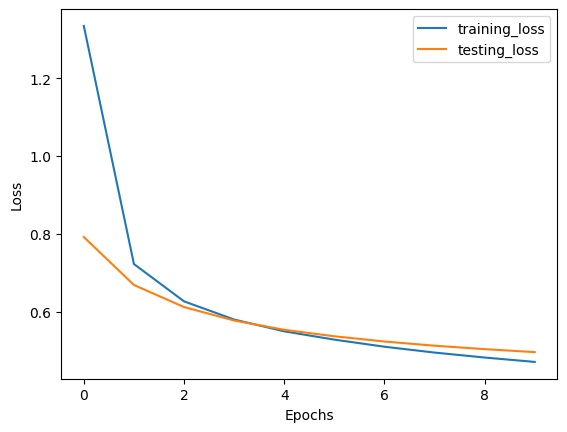

In [21]:
from torch.utils.data import DataLoader
batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
training_loss_overfit = []
testing_loss_overfit = []
learning_rate = 0.01
max_epochs = 10
for epoch in range(max_epochs):
    train_loss = 0.0
    test_loss = 0.0
    total = 0.0
    correct = 0.0
    for idx, data in enumerate(train_loader):
        features, labels = data

        # transfer to gpu, because model is on gpu
        features = features.cuda()
        labels = labels.cuda()

        # reshape 28x28 image features to single 784 row
        probs = model_over(features.reshape([-1, 784]))

        # calculate cross entropy loss : softmax is already applies on probs (output data), 
        # labels will have to be one-hot encoded
        loss = ce_loss(probs, labels)

        train_loss += loss.item()
#                 print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))
        # once loop is done, store per epoch training_loss to global list (take mean of iteration training loss)

    # zeroing out the grdients equiv to optimizer.zero_grad()
        for param in model_over.parameters():
            param.grad = None

    # backward pass
        loss.backward()

    # equiv to optimizer.step()
        for name, param in model_over.named_parameters():
          # Write paramtere update routine here:
          # --------------
            new_param = param - learning_rate * param.grad
          # --------------
            with torch.no_grad():
                param.copy_(new_param) # Copies the elements from src into self tensor and returns self.
                
    training_loss_overfit.append(train_loss/len(train_loader))

    for idx, data in enumerate(test_loader):
        features, labels = data
        features = features.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            # model
            probs = model_over(features.reshape([-1, 784]))

            max_probab_vector = torch.argmax(probs, dim=1)
            
            loss = ce_loss(probs, labels)
            test_loss += loss.item()

            total += labels.numel()
            correct += sum(max_probab_vector == labels).item()
    testing_loss_overfit.append(test_loss/len(test_loader))

print(training_loss_overfit)
print(testing_loss_overfit)

plt.plot(training_loss_overfit, label='training_loss')
plt.plot(testing_loss_overfit, label='testing_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [22]:
model_over = OverfitNet().cuda()

[1.4869564394561612, 0.6904242111712086, 0.6098134651476023, 0.5653820171648142, 0.5361523275472679, 0.5150701975335881, 0.49825792288293647, 0.4845208768941918, 0.47327270738932553, 0.4633274479788177, 0.45494245631354197, 0.44687999815356977, 0.4399365533371361, 0.43305121331798785, 0.42674391853566074, 0.42039857956827903, 0.4147420616782441, 0.41001286859415015, 0.4052601809404334, 0.4007066263228047]
[0.7817333161830902, 0.6738584935665131, 0.6211349606513977, 0.5902888417243958, 0.5680003106594086, 0.5511789143085479, 0.5374370098114014, 0.5261927127838135, 0.5167117804288864, 0.5081901282072068, 0.49907206594944, 0.4914690136909485, 0.484772390127182, 0.4789024591445923, 0.47377915382385255, 0.46940708458423613, 0.46493351459503174, 0.46062969267368314, 0.45670415461063385, 0.45314877927303315]


<function matplotlib.pyplot.show(close=None, block=None)>

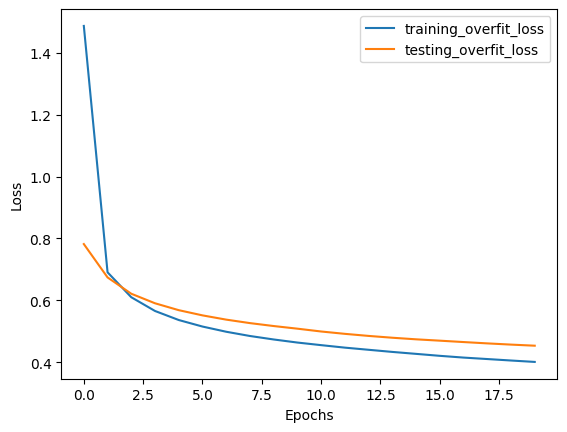

In [23]:
from torch.utils.data import DataLoader
batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
training_loss_overfit_20 = []
testing_loss_overfit_20 = []
learning_rate = 0.01
max_epochs = 20
for epoch in range(max_epochs):
    train_loss = 0.0
    test_loss = 0.0
    total = 0.0
    correct = 0.0
    for idx, data in enumerate(train_loader):
        features, labels = data

        # transfer to gpu, because model is on gpu
        features = features.cuda()
        labels = labels.cuda()

        # reshape 28x28 image features to single 784 row
        probs = model_over(features.reshape([-1, 784]))

        # calculate cross entropy loss : softmax is already applies on probs (output data), 
        # labels will have to be one-hot encoded
        loss = ce_loss(probs, labels)

        train_loss += loss.item()
#                 print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))
        # once loop is done, store per epoch training_loss to global list (take mean of iteration training loss)

    # zeroing out the grdients equiv to optimizer.zero_grad()
        for param in model_over.parameters():
            param.grad = None

    # backward pass
        loss.backward()

    # equiv to optimizer.step()
        for name, param in model_over.named_parameters():
          # Write paramtere update routine here:
          # --------------
            new_param = param - learning_rate * param.grad
          # --------------
            with torch.no_grad():
                param.copy_(new_param) # Copies the elements from src into self tensor and returns self.
                
    training_loss_overfit_20.append(train_loss/len(train_loader))

    for idx, data in enumerate(test_loader):
        features, labels = data
        features = features.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            # model
            probs = model_over(features.reshape([-1, 784]))

            max_probab_vector = torch.argmax(probs, dim=1)
            
            loss = ce_loss(probs, labels)
            test_loss += loss.item()

            total += labels.numel()
            correct += sum(max_probab_vector == labels).item()
    testing_loss_overfit_20.append(test_loss/len(test_loader))

print(training_loss_overfit_20)
print(testing_loss_overfit_20)

plt.plot(training_loss_overfit_20, label='training_overfit_loss')
plt.plot(testing_loss_overfit_20, label='testing_overfit_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [24]:
class UnderfitNet(torch.nn.Module):
  def __init__(self):
    super(UnderfitNet, self).__init__()
    self.layer_1 = CustomLinearLayer(784, 8)
    self.layer_2 = CustomLinearLayer(8, 10)

    self.activation = torch.nn.ReLU()
    self.softmax = torch.nn.Softmax(dim=-1)
  
  def forward(self, x):
    output = self.layer_1(x)
    output = self.activation(output)
    output = self.layer_2(output)
    output = self.softmax(output)
    return output

In [25]:
model_under = UnderfitNet().cuda()

[2.282727815666977, 2.240483449429882, 2.187178071664304, 2.106879934972646, 2.003632029708551]
[2.259265327453613, 2.215021538734436, 2.148933506011963, 2.0551167726516724, 1.9459914565086365]


<function matplotlib.pyplot.show(close=None, block=None)>

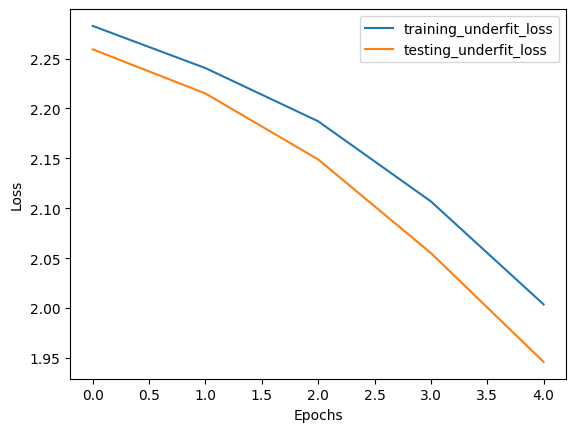

In [26]:
from torch.utils.data import DataLoader
batch_size = 1024
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
training_loss_underfit = []
testing_loss_underfit = []
learning_rate = 0.01
max_epochs = 5
for epoch in range(max_epochs):
    train_loss = 0.0
    test_loss = 0.0
    total = 0.0
    correct = 0.0
    for idx, data in enumerate(train_loader):
        features, labels = data

        # transfer to gpu, because model is on gpu
        features = features.cuda()
        labels = labels.cuda()

        # reshape 28x28 image features to single 784 row
        probs = model_under(features.reshape([-1, 784]))

        # calculate cross entropy loss : softmax is already applies on probs (output data), 
        # labels will have to be one-hot encoded
        loss = ce_loss(probs, labels)

        train_loss += loss.item()
#                 print("Epoch {0}/{1} Iteration {2}/{3} Loss {4}: ".format(epoch, max_epochs, idx, len(train_loader), loss))
        # once loop is done, store per epoch training_loss to global list (take mean of iteration training loss)

    # zeroing out the grdients equiv to optimizer.zero_grad()
        for param in model_under.parameters():
            param.grad = None

    # backward pass
        loss.backward()

    # equiv to optimizer.step()
        for name, param in model_under.named_parameters():
          # Write paramtere update routine here:
          # --------------
            new_param = param - learning_rate * param.grad
          # --------------
            with torch.no_grad():
                param.copy_(new_param) # Copies the elements from src into self tensor and returns self.
                
    training_loss_underfit.append(train_loss/len(train_loader))

    for idx, data in enumerate(test_loader):
        features, labels = data
        features = features.cuda()
        labels = labels.cuda()

        with torch.no_grad():
            # model
            probs = model_under(features.reshape([-1, 784]))

            max_probab_vector = torch.argmax(probs, dim=1)
            
            loss = ce_loss(probs, labels)
            test_loss += loss.item()

            total += labels.numel()
            correct += sum(max_probab_vector == labels).item()
    testing_loss_underfit.append(test_loss/len(test_loader))

print(training_loss_underfit)
print(testing_loss_underfit)

plt.plot(training_loss_underfit, label='training_underfit_loss')
plt.plot(testing_loss_underfit, label='testing_underfit_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

Since our dataset is well balanced, seen from the support in the above classification reports, to represent underfitting we cannot really make alterations to dataset to demonstrate underfitting.
Here we can clearly see one possible example of the model underfitting and overfitting.
For underfitting,I decreased the number of epochs as well as the first layer dimensions to 784 x 8, which demonstrates one possible case of underfitting that is, the model has not been trained enough on train data, meaning the network has not been able to find relevant patterns in the data in the given number of epochs.
In case of overfitting, I did increase the number of layers, but not as much as underfit, because the aim for a good fit is to really find a balance where the model doesn't learn too much or too less. In terms of epochs, we can see from the two graphs above that, if we move past the fixed number of 10 epochs, the testing loss eventually overshoots the training loss, which means that the model is training too much, so much that it is generalizing the 
train data too well.

<function matplotlib.pyplot.show(close=None, block=None)>

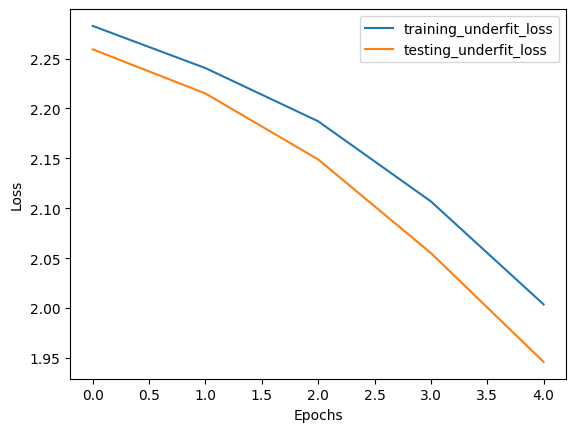

In [29]:
plt.plot(training_loss_underfit, label='training_underfit_loss')
plt.plot(testing_loss_underfit, label='testing_underfit_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show







<function matplotlib.pyplot.show(close=None, block=None)>

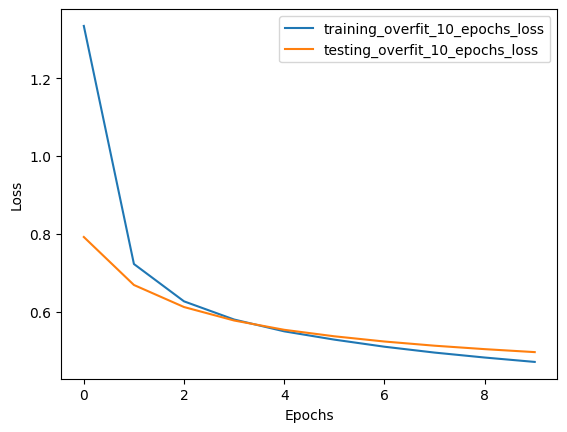

In [28]:
plt.plot(training_loss_overfit, label='training_overfit_10_epochs_loss')
plt.plot(testing_loss_overfit, label='testing_overfit_10_epochs_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

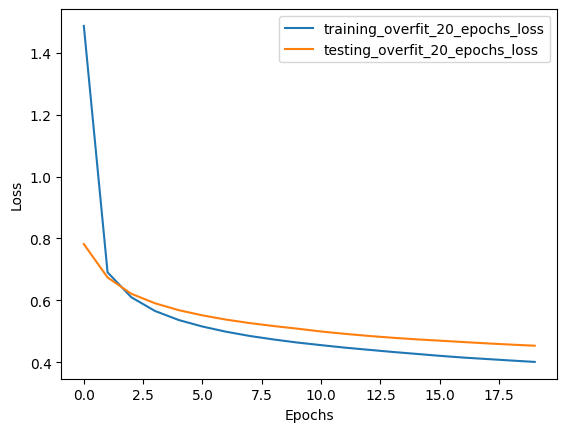

In [30]:
plt.plot(training_loss_overfit_20, label='training_overfit_20_epochs_loss')
plt.plot(testing_loss_overfit_20, label='testing_overfit_20_epochs_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show